In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import string
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

import seaborn as sns

sns.set(font_scale=1.4, style="whitegrid")
%config InlineBackend.figure_format='retina'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [3]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

--2025-01-30 22:45:00--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2025-01-30 22:45:01 (9.89 MB/s) - ‘onegin.txt’ saved [262521/262521]



In [4]:
with open("onegin.txt", "r") as iofile:
    text = iofile.readlines()

text = [x.replace("\t\t", "") for x in text]

In [5]:
text = "".join(text).lower()

tokens = sorted(set(text))

In [6]:
token_to_idx = {char: idx for idx, char in enumerate(tokens)}

idx_to_token = {idx: char for idx, char in enumerate(tokens)}

print(f"Количество уникальных символов: {len(tokens)}")

Количество уникальных символов: 83


In [7]:
class TextDataset(Dataset):
    def __init__(self, text, seq_len, token_to_idx):
        self.seq_length = seq_len
        self.token_to_idx = token_to_idx
        self.text = text
        self.num_sequences = len(text) - seq_len

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        seq = self.text[idx : idx + self.seq_length]
        target = self.text[idx + 1 : idx + self.seq_length + 1]
        seq_idx = [self.token_to_idx[char] for char in seq]
        target_idx = [self.token_to_idx[char] for char in target]
        return torch.tensor(seq_idx, dtype=torch.long), torch.tensor(
            target_idx, dtype=torch.long
        )


dataset = TextDataset(text, 100, token_to_idx)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

In [8]:
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super(CharLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.func = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embed(x)
        out, hidden = self.lstm(x, hidden)
        out = self.func(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return (
            torch.zeros(self.num_layers, batch_size, self.hidden_size),
            torch.zeros(self.num_layers, batch_size, self.hidden_size),
        )

In [9]:
model_lstm = CharLSTM(len(tokens), 128, 266, 2).to(device)

model_lstm.train()
criterion = nn.CrossEntropyLoss()
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

In [10]:
losses_lstm = []

vocab_size = len(tokens)
num_epochs = 20

model_lstm.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch, (seq, target) in enumerate(dataloader):
        batch_size = seq.size(0)
        seq = seq.to(device)
        target = target.to(device)

        hidden = model_lstm.init_hidden(batch_size)
        hidden = tuple([h.to(seq.device) for h in hidden])

        optimizer_lstm.zero_grad()
        output, hidden = model_lstm(seq, hidden)
        hidden = tuple([h.detach() for h in hidden])
        loss = criterion(output.view(-1, vocab_size), target.view(-1))
        loss.backward()
        optimizer_lstm.step()

        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(dataloader)
    losses_lstm.append(avg_loss)
    print(f"LSTM epoch {epoch+1}/{num_epochs}, loss: {avg_loss:.4f}")

LSTM epoch 1/20, loss: 1.7993
LSTM epoch 2/20, loss: 0.8927
LSTM epoch 3/20, loss: 0.3696
LSTM epoch 4/20, loss: 0.2371
LSTM epoch 5/20, loss: 0.2034
LSTM epoch 6/20, loss: 0.1866
LSTM epoch 7/20, loss: 0.1756
LSTM epoch 8/20, loss: 0.1677
LSTM epoch 9/20, loss: 0.1617
LSTM epoch 10/20, loss: 0.1569
LSTM epoch 11/20, loss: 0.1528
LSTM epoch 12/20, loss: 0.1494
LSTM epoch 13/20, loss: 0.1466
LSTM epoch 14/20, loss: 0.1442
LSTM epoch 15/20, loss: 0.1419
LSTM epoch 16/20, loss: 0.1400
LSTM epoch 17/20, loss: 0.1384
LSTM epoch 18/20, loss: 0.1366
LSTM epoch 19/20, loss: 0.1354
LSTM epoch 20/20, loss: 0.1341


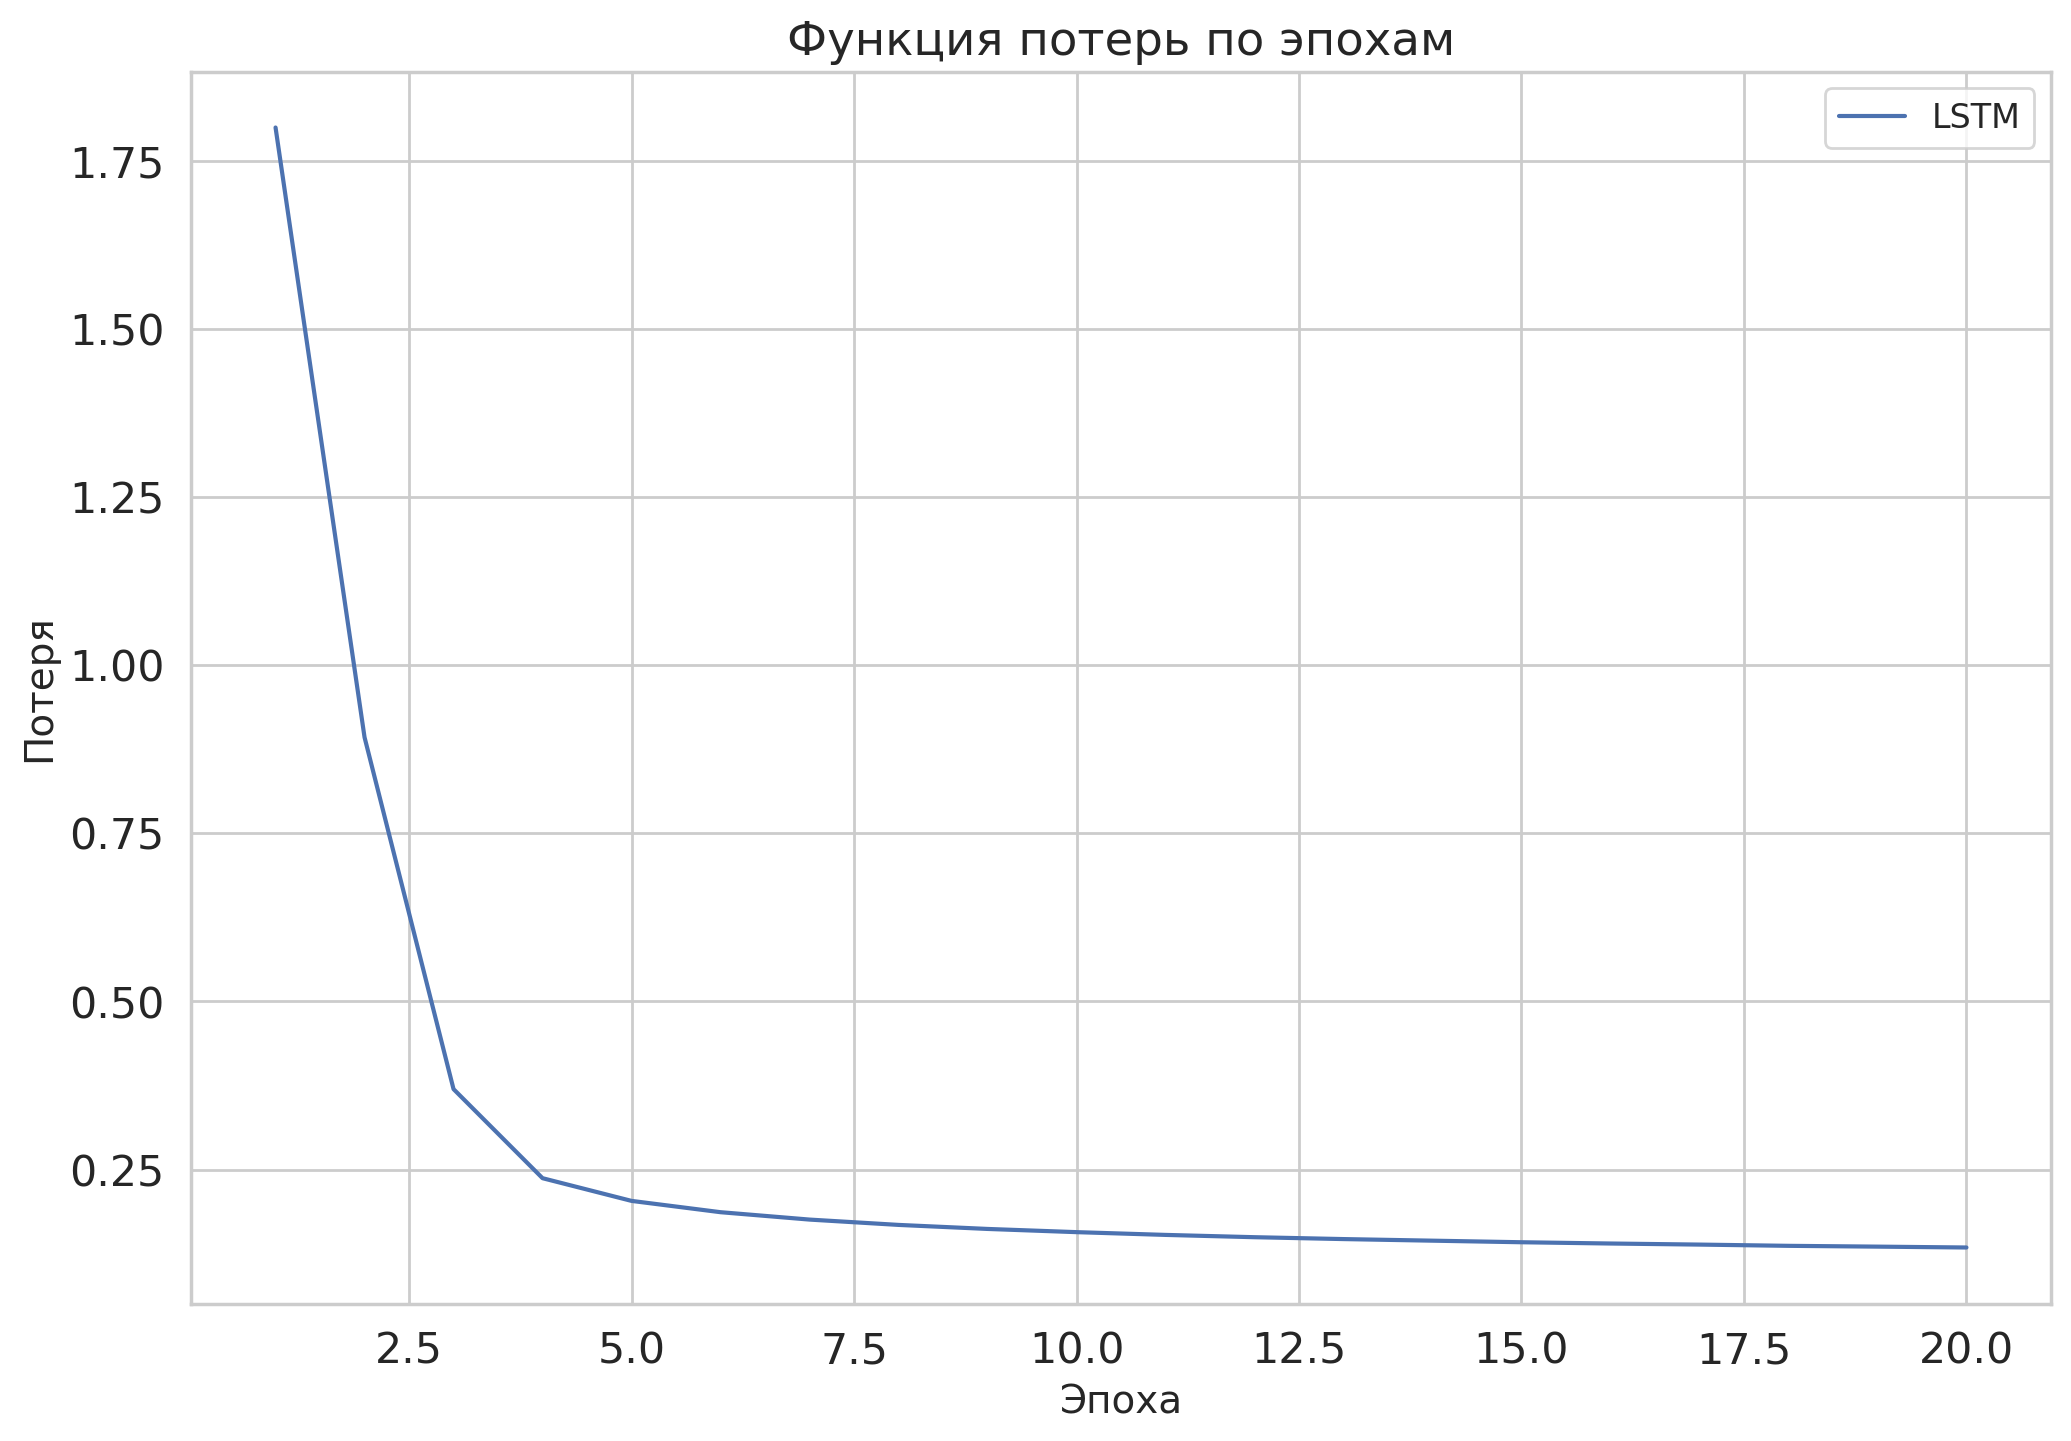

In [11]:
plt.figure(figsize=(12, 8))

plt.plot(range(1, num_epochs + 1), losses_lstm, label="LSTM")

plt.title("Функция потерь по эпохам")
plt.xlabel("Эпоха", fontsize=14)
plt.ylabel("Потеря", fontsize=14)

plt.legend(fontsize=12)
plt.show()

In [12]:
def generate_lstm(
    model,
    token_to_id,
    idx_to_token,
    seed_phrase="Привт",
    max_length=500,
    temperature=1.0,
    device="cpu",
):
    model.eval()
    batch_size = 1

    hidden = model.init_hidden(batch_size)

    hidden = tuple(h.to(device) for h in hidden)

    input_seq = [token_to_id.get(char, token_to_id[" "]) for char in seed_phrase]
    input_seq = torch.tensor([input_seq], dtype=torch.long).to(device)

    generated = seed_phrase

    with torch.no_grad():
        for i in range(len(seed_phrase) - 1):
            _, hidden = model(input_seq[:, i].unsqueeze(1), hidden)

        last_char = input_seq[:, -1]

        for _ in range(max_length - len(seed_phrase)):
            output, hidden = model(last_char.unsqueeze(1), hidden)

            output = output[:, -1, :] / temperature
            probs = F.softmax(output, dim=-1).squeeze().cpu().numpy()
            next_idx = np.random.choice(len(idx_to_token), p=probs)
            next_char = idx_to_token[next_idx]
            generated += next_char
            last_char = torch.tensor([next_idx], dtype=torch.long).to(device)

    return generated

In [13]:
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
seed_phrase = "так думал молодой повеса"

with open("output.txt", "w") as f:
    for temp in temperatures:
        print(f"\n температура: {temp} ")
        f.write(f"\n температура: {temp} ")
        generated_text = generate_lstm(
            model_lstm,
            token_to_idx,
            idx_to_token,
            seed_phrase=seed_phrase,
            temperature=temp,
            device=device,
        )
        print(generated_text)
        f.write(generated_text)


 температура: 0.1 
так думал молодой повеса,
летя в пыли на почтовых,
всевышней волею зевеса
наследник всех своих родных. —
друзья людмилы и руссо.
отец ее был добрый малый,
в прошедшем веке запоздалый;
но в книгах не видал вреда;
буян, пред этой ясностию взгляда,
пред этой нежной простотой,
пред этой резвою душой!..
он смотрит в сладком умиленье;
он видит: он еще любим;
уж он, раскаяньем томим,
готов просить у ней прощенье,
трепещет, не находит слов,
он счастлив, он почти здоров…



xv. xvi. xvii

и вновь задумчи

 температура: 0.2 
так думал молодой повеса,
летя в пыли на почтовых,
всевышней волею зевеса
наследник всех своих родных. —
друзья людмилы и руссо.
отец ее был добрый малый,
в прошедшем веке запоздалый;
но в книгах не видал вреда;
буян, пред ними отворилась,
и таня входит в дом пустой,
где жил недавно наш герой.
она глядит: забытый в зале
кий на бильярде отдыхал,
на смятом канапе лежал
манежный хлыстик. таня дале;
старушка ей: «а вот камин;
здесь барин сиживал один.



xvii

In [14]:
torch.save(model_lstm.state_dict(), "char_lstm_model.pth")